# 4.2b - Compare all pairs of classes. How easy is to distinguish between them?

In [1]:
import os
import sys
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.2b-pairs'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

In [4]:
def CM(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(classes, (32,), strides=1)(last)
    last = MaxPooling1D(pool_size=481, strides=1)(last)
    last = Flatten()(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

# Create models

In [5]:
cats = rawset.categories
tsets, vsets = rawset.rnd_split_fraction_by_category(0.5)
tsets = tsets.by_category()
vsets = vsets.by_category()

In [6]:
if os.path.exists(result_dir + "/2classes.tsv"):
    os.remove(result_dir + "/2classes.tsv")
r = report.Reporter2(result_dir + '/2classes.tsv')
for i in range(len(cats)):
    for j in range(i+1, len(cats)):
        print(cats[i], cats[j])
        mycats = [cats[i], cats[j]]
        myset = rawset.filter(lambda x: rawset.category_from(x) in mycats)
        myset.rebuild_categories()
        tset, vset = myset.rnd_split_fraction_by_category(0.5)

        model = CM(2, 256)
        result = Trainer(
            model,
            xs_encoder='one_hot',
            batch_size=100,
            steps_per_epoch=28,
            validation_steps=28,
            patience=10,
        ).train(tset, vset)
        h5_path = os.path.join(result_dir, '%s_%s.h5' % (cats[i], cats[j]))
        model.save(h5_path)
        print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])
        r.line(cat1=cats[i],
               cat2=cats[j],
               elapsed=result.elapsed,
               **report.report_epochs(**result._asdict()),
               **report.report_metrics(**result._asdict()),
              )
r.close()

csv dbase3
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
1040.7059528827667 0.99785715
csv doc
1807.5884442329407 0.9892857
csv dwf
463.4997503757477 0.99857146
csv eps
1096.6623351573944 0.9967857
csv f
1840.1324837207794 0.97321427
csv gif
530.7885355949402 0.99857146
csv gz
544.7575821876526 1.0
csv hlp
1321.7435710430145 0.98285717
csv html
1095.6041548252106 0.9753571
csv java
1280.3371996879578 0.9917857
csv jpg
1003.9277517795563 0.99535716
csv kml
777.9098374843597 0.97321427
csv kmz
570.4467887878418 0.9992857
csv log
1655.3700983524323 0.9767857
csv pdf
1348.151804447174 0.99392855
csv png
656.4528510570526 0.99892855
csv pps
825.3880190849304 0.99785715
csv ppt
1302.834608078003 0.99285716
csv pptx
623.9143452644348 0.9982143
csv ps
1777.547687292099 0.99535716
csv rtf
1453.8349051475525 0.98785716
csv sql
1965.56968832016 0.99142855
csv swf
1170.3168585300446 0.9992857
csv txt
1146.039677143097 0.941428

745.699732542038 0.99785715
html ps
3110.528810739517 0.9778572
html rtf
1276.7162024974823 0.98
html sql
1710.6198737621307 0.9653571
html swf
1379.5632557868958 0.99607146
html txt
1304.119377374649 0.93142855
html wp
1675.4383084774017 0.9835714
html xls
2218.096474170685 0.9935714
html xml
1459.152456521988 0.92285717
java jpg
601.0510220527649 0.9932143
java kml
1138.7862904071808 0.9885714
java kmz
973.7142696380615 0.99964285
java log
1896.977100610733 0.96107143
java pdf
1460.4513635635376 0.99214286
java png
643.7166049480438 0.99714285
java pps
1419.2599132061005 0.99535716
java ppt
913.6596112251282 0.99214286
java pptx
619.5984034538269 0.9975
java ps
2428.4701998233795 0.9935714
java rtf
2127.7674345970154 0.99464285
java sql
2252.1041026115417 0.9442857
java swf
897.0537173748016 0.99964285
java txt
1591.1674356460571 0.9717857
java wp
1230.2265839576721 0.98571426
java xls
2132.6622173786163 0.98785716
java xml
2112.269058942795 0.9667857
jpg kml
694.3790986537933 0.9957

# Load results

In [7]:
data = pd.read_csv(result_dir + '/2classes.tsv', sep='\t')
data

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,csv,dbase3,1040.705953,24,0.997857,0.997857
1,csv,doc,1807.588444,43,0.989286,0.989286
2,csv,dwf,463.499750,11,0.998571,0.998571
3,csv,eps,1096.662335,23,0.996786,0.996786
4,csv,f,1840.132484,42,0.973214,0.973214
...,...,...,...,...,...,...
373,txt,xls,2167.709688,58,0.980714,0.980714
374,txt,xml,1446.690542,38,0.960000,0.960000
375,wp,xls,2398.626066,64,0.958929,0.958929
376,wp,xml,974.416577,25,0.979643,0.979643


In [8]:
data = data.sort_values(['val_categorical_accuracy'])
data[data['val_categorical_accuracy'] < 0.7]

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
323,pps,ppt,846.570197,19,0.551429,0.551429
81,dwf,gz,2270.186561,42,0.575357,0.575357
90,dwf,png,2212.567902,39,0.599643,0.599643
345,pptx,swf,1030.596483,25,0.606786,0.606786
318,png,swf,917.677584,21,0.607857,0.607857
324,pps,pptx,978.030139,22,0.615000,0.615000
97,dwf,swf,1431.272200,29,0.631786,0.631786
183,gz,swf,1388.673591,26,0.633571,0.633571
314,png,pptx,720.149178,16,0.634286,0.634286
328,pps,swf,1280.351370,29,0.634286,0.634286


In [9]:
data2 = data.apply(
    lambda x: pd.Series(
        [
            rawset.cat_to_ix[x.cat1],
            rawset.cat_to_ix[x.cat2], 
            x.val_categorical_accuracy
        ], index=['cat1', 'cat2', 'val_acc'])
    , axis=1)
data2

,cat1,cat2,val_acc
323,17.0,18.0,0.551429
81,3.0,7.0,0.575357
90,3.0,16.0,0.599643
345,19.0,23.0,0.606786
318,16.0,23.0,0.607857
...,...,...,...
154,6.0,14.0,1.000000
152,6.0,12.0,1.000000
273,13.0,14.0,1.000000
132,5.0,13.0,1.000000


In [10]:
cat_acc = {}
for i, d in data.iterrows():
    cat1 = d['cat1']
    cat2 = d['cat2']
    cat_acc[cat1] = cat_acc.get(cat1, list())
    cat_acc[cat2] = cat_acc.get(cat2, list())
    cat_acc[cat1].append(d['val_categorical_accuracy'])
    cat_acc[cat2].append(d['val_categorical_accuracy'])    

No handles with labels found to put in legend.


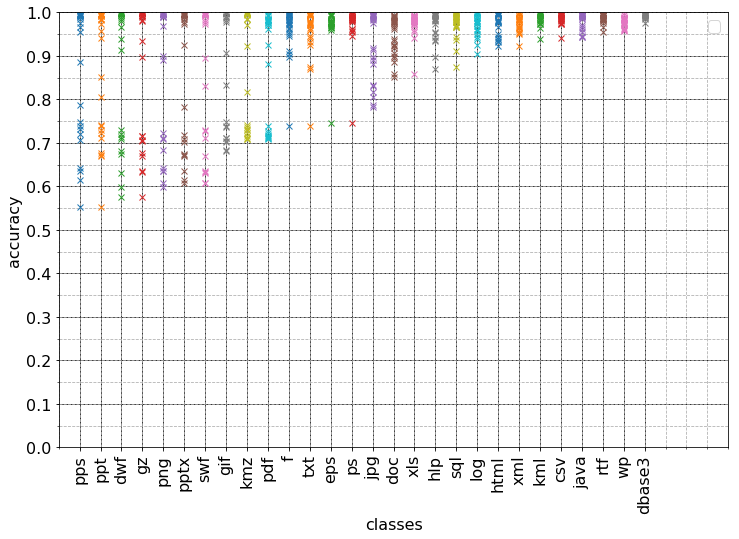

In [11]:
from matplotlib.ticker import MultipleLocator
loc='upper right'
fig = plt.figure(figsize=(12,8))
for k, v in cat_acc.items():
    plt.plot(*zip(*[(k, x) for x in v]), 'x')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('classes', fontsize=16)
plt.xlim((-1, 31))
plt.ylim((-0, 1))
ax1 = plt.gca()
# ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid(linestyle='-', color='k', which='major')
plt.grid(linestyle='--', which='minor')
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
plt.legend(loc=loc, prop={'size': 16})
plt.xticks(rotation=90)
#     plt.savefig('acc.png')
plt.show()    

In [12]:
data.min()

cat1                             csv
cat2                          dbase3
elapsed                        463.5
Epochs                            11
val_binary_accuracy         0.551429
val_categorical_accuracy    0.551429
dtype: object

In [13]:
with open(result_dir + '/nclasses.tsv', 'w') as f:
    f.write('n\tcats\tval_categorical_accuracy\n')
    for i, x in data.iterrows():
        s = '2\t{}\t{}\n'.format(x.cat1+','+x.cat2,x.val_categorical_accuracy)
        f.write(s)

# Add pairs of classes to graph 4.2a

In [14]:
from matplotlib.ticker import MultipleLocator
def plot_acc(xs, ys, labels=None, loc='upper right', alpha_on=None):
    fig = plt.figure(figsize=(12,8))
#     fig.yaxis.set_minor_locator()
    if labels is None:
        labels = [None for x in xs]
    for x, y, label, mark in zip(xs, ys, labels, ['bx', 'g-', 'r*', '.mD']):
        plt.plot(x[x==alpha_on], y[x==alpha_on], mark, alpha=0.1, label='')
        plt.plot(x[x!=alpha_on], y[x!=alpha_on], mark, label=label)
    ax1 = plt.gca()
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of classes', fontsize=16)
    plt.xlim((-0, 31))
    plt.ylim((-0, 1))
    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(linestyle='-', color='k', which='major')
    plt.grid(linestyle='--', which='minor')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    plt.legend(loc=loc, prop={'size': 16})
#     plt.savefig('acc.png')

In [15]:
data42a = pd.read_csv('results/4.2a-nclasses/nclasses.tsv', sep='\t')
data42b = pd.read_csv('results/4.2b-pairs/nclasses.tsv', sep='\t')
mdata = pd.concat([data42a, data42b])

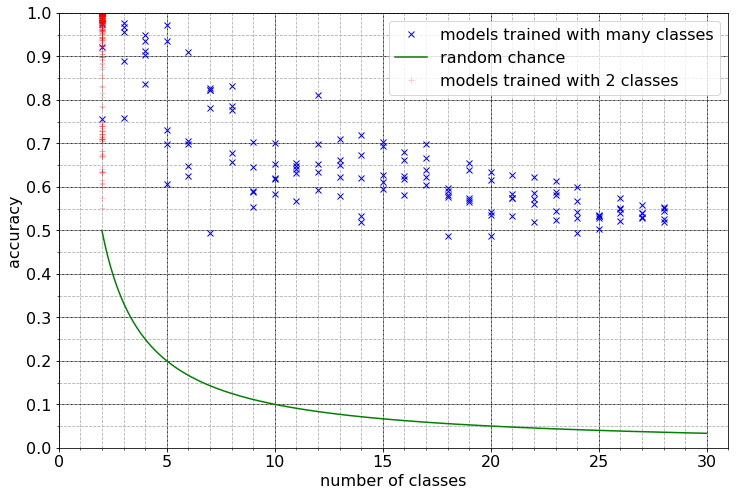

In [16]:
x = np.arange(2,30,0.01)
y = 1/x
plot_acc([data42a['n'], x], [data42a['val_categorical_accuracy'], y], ['models trained with many classes', 'random chance'])
plt.plot(data42b['n'], data42b['val_categorical_accuracy'], 'r+', alpha=0.2, label='models trained with 2 classes')
plt.legend(loc='upper right', prop={'size': 16})

# PCA

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=2)

In [19]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.500000,0.997857,0.989286,0.998571,0.996786,0.973214,0.998571,1.000000,0.982857,0.975357,...,0.992857,0.998214,0.995357,0.987857,0.991429,0.999286,0.941429,0.983929,0.983571,0.980000
1,0.997857,0.500000,0.992500,0.999643,0.996429,0.997500,1.000000,0.999643,0.995714,0.995000,...,0.993929,0.996429,0.998214,0.998571,0.987500,1.000000,0.993571,0.994643,0.992857,0.984643
2,0.989286,0.992500,0.500000,0.939643,0.979286,0.970357,0.906429,0.933214,0.994643,0.981429,...,0.851429,0.925714,0.979643,0.987143,0.967143,0.894643,0.978571,0.961071,0.857857,0.974643
3,0.998571,0.999643,0.939643,0.500000,0.967143,0.993929,0.681429,0.575357,0.997143,1.000000,...,0.729286,0.674286,0.989286,0.998214,1.000000,0.631786,0.994643,0.984286,0.981071,0.998214
4,0.996786,0.996429,0.979286,0.967143,0.500000,0.976429,0.978571,0.979286,0.992143,0.980000,...,0.973214,0.978929,0.745714,0.967143,0.978571,0.993929,0.963214,0.975714,0.976786,0.984643
5,0.973214,0.997500,0.970357,0.993929,0.976429,0.500000,0.999643,1.000000,0.897857,0.949643,...,0.996429,0.991429,0.962857,0.981429,0.911786,0.994643,0.739286,0.963929,0.984643,0.955714
6,0.998571,1.000000,0.906429,0.681429,0.978571,0.999643,0.500000,0.704643,1.000000,0.998929,...,0.738929,0.701786,0.990000,0.998571,0.992857,0.710357,0.997857,0.988214,0.982143,0.999643
7,1.000000,0.999643,0.933214,0.575357,0.979286,1.000000,0.704643,0.500000,0.999643,0.999643,...,0.676429,0.668929,0.994286,0.991429,0.998214,0.633571,0.995000,0.983214,0.988571,1.000000
8,0.982857,0.995714,0.994643,0.997143,0.992143,0.897857,1.000000,0.999643,0.500000,0.935000,...,0.995714,0.994643,0.987500,0.991429,0.937500,0.998214,0.870714,0.972500,0.980357,0.952143
9,0.975357,0.995000,0.981429,1.000000,0.980000,0.949643,0.998929,0.999643,0.935000,0.500000,...,0.994643,0.997857,0.977857,0.980000,0.965357,0.996071,0.931429,0.983571,0.993571,0.922857


In [20]:
data6 = pca.fit_transform(data5)

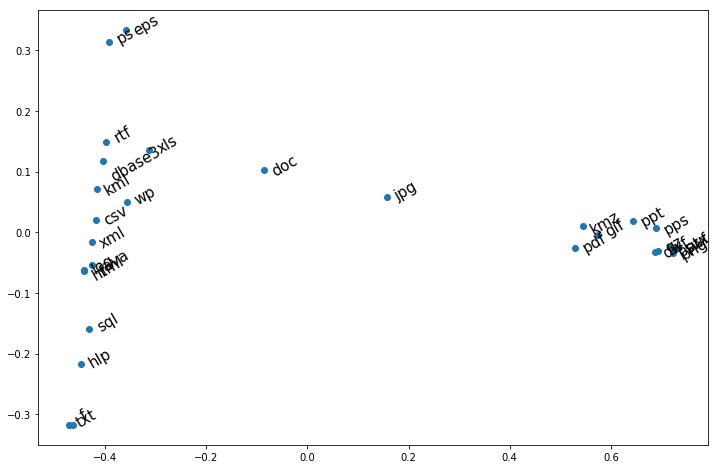

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data6[:,0], data6[:,1], 'o')

for i in range(28):
    t = ax.annotate(rawset.ix_to_cat[i], (data6[i,0]+0.01, data6[i,1]+0.01),fontsize=15)
    t.set_rotation(30)

In [22]:
data6[:,0]>0.4

array([False, False, False,  True, False, False,  True,  True, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True, False, False, False,
       False])

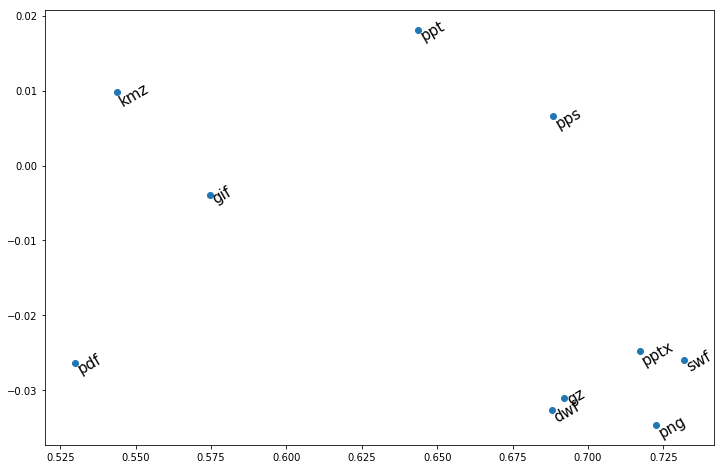

In [23]:
data7 = data6[data6[:,0]>0.4]
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data7[:,0], data7[:,1], 'o')
for i in range(len(data6)):
    if data6[i,0] < 0.4:
        continue
    t = ax.annotate(rawset.ix_to_cat[i], (data6[i,0]+0.0, data6[i,1]+0.0),fontsize=15)
    t.set_rotation(30)

# Multi-dimensional scaling

In [24]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.500000,0.997857,0.989286,0.998571,0.996786,0.973214,0.998571,1.000000,0.982857,0.975357,...,0.992857,0.998214,0.995357,0.987857,0.991429,0.999286,0.941429,0.983929,0.983571,0.980000
1,0.997857,0.500000,0.992500,0.999643,0.996429,0.997500,1.000000,0.999643,0.995714,0.995000,...,0.993929,0.996429,0.998214,0.998571,0.987500,1.000000,0.993571,0.994643,0.992857,0.984643
2,0.989286,0.992500,0.500000,0.939643,0.979286,0.970357,0.906429,0.933214,0.994643,0.981429,...,0.851429,0.925714,0.979643,0.987143,0.967143,0.894643,0.978571,0.961071,0.857857,0.974643
3,0.998571,0.999643,0.939643,0.500000,0.967143,0.993929,0.681429,0.575357,0.997143,1.000000,...,0.729286,0.674286,0.989286,0.998214,1.000000,0.631786,0.994643,0.984286,0.981071,0.998214
4,0.996786,0.996429,0.979286,0.967143,0.500000,0.976429,0.978571,0.979286,0.992143,0.980000,...,0.973214,0.978929,0.745714,0.967143,0.978571,0.993929,0.963214,0.975714,0.976786,0.984643
5,0.973214,0.997500,0.970357,0.993929,0.976429,0.500000,0.999643,1.000000,0.897857,0.949643,...,0.996429,0.991429,0.962857,0.981429,0.911786,0.994643,0.739286,0.963929,0.984643,0.955714
6,0.998571,1.000000,0.906429,0.681429,0.978571,0.999643,0.500000,0.704643,1.000000,0.998929,...,0.738929,0.701786,0.990000,0.998571,0.992857,0.710357,0.997857,0.988214,0.982143,0.999643
7,1.000000,0.999643,0.933214,0.575357,0.979286,1.000000,0.704643,0.500000,0.999643,0.999643,...,0.676429,0.668929,0.994286,0.991429,0.998214,0.633571,0.995000,0.983214,0.988571,1.000000
8,0.982857,0.995714,0.994643,0.997143,0.992143,0.897857,1.000000,0.999643,0.500000,0.935000,...,0.995714,0.994643,0.987500,0.991429,0.937500,0.998214,0.870714,0.972500,0.980357,0.952143
9,0.975357,0.995000,0.981429,1.000000,0.980000,0.949643,0.998929,0.999643,0.935000,0.500000,...,0.994643,0.997857,0.977857,0.980000,0.965357,0.996071,0.931429,0.983571,0.993571,0.922857


In [25]:
from sklearn.manifold import MDS

In [26]:
mds = MDS(n_components=2,max_iter=3000, eps=1e-9,
          n_jobs=1)

In [27]:
data7 = mds.fit_transform(data5)

/home/atila.alr/.local/lib/python3.6/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


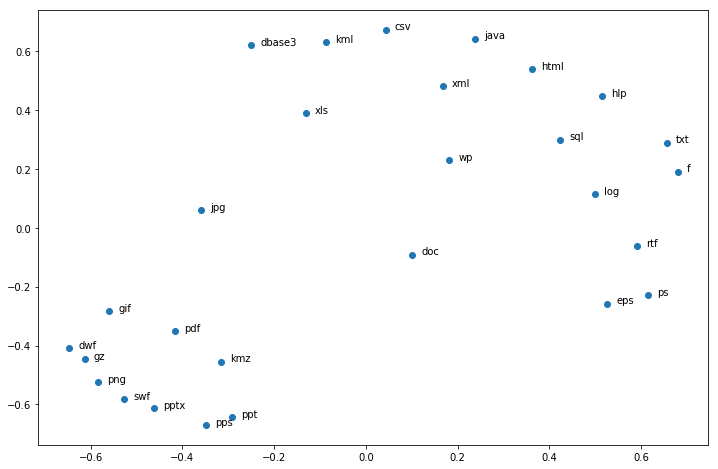

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data7[:,0], data7[:,1], 'o')
for i in range(28):
    ax.annotate(rawset.ix_to_cat[i], (data7[i,0]+0.02, data7[i,1]))